In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.tag.stanford import StanfordPOSTagger as tagger
import treetaggerwrapper
from sklearn.manifold import TSNE

# Data Processing

In [2]:
class Data():
    def __init__(self, unique_characters=[], data=[], shuffle=False):
        self.unique_characters = unique_characters
        
        self.unique_characters.insert(0, u"<EOS>") 
        self.unique_characters.insert(0, u"<GO>") 
        self.unique_characters.insert(0, u"<PAD>") 
        
        self.num_unique_chars = len(self.unique_characters)
        
        self.char2index = {v: i for i, v in enumerate(self.unique_characters)}
        self.index2char = {i: v for i, v in enumerate(self.unique_characters)}
        
        self.embedding_size = 5
        self.embeddings = tf.Variable(tf.random_uniform([len(self.char2index), self.embedding_size], -1.0, 1.0))
        
        self.current_index = 0
        
        self.data = np.array(data)
        self.length = len(self.data)
        self.permuted_indices = np.random.permutation(self.length)
        
        self.shuffle = shuffle
        
        
    def to_one_hot(self, batches, as_tf_tensor=False):
        """
        Takes data of the shape [batch, characters]
        and converts it into a one hot representation
        to be used by a LSTM or other neural network
        Example: 
                [
                    ['a', 'b'],
                    ['a', 'c']
                ]
                Converts into one-hot representation ->
                [
                    [[1, 0, 0], [0, 1, 0]],
                    [[1, 0, 0], [0, 0, 1]]
                ]
        
        Params:
            batches: Batch of character input data
            as_tensor: If the one_hot representation should be a np array or 
                       a tensorflow tensor.
            
        Returns:
            A one hot tensor representation of the input batch data
        """
#         char_indices = []
#         for batch in batches:
#             char_indices.append([self.char2index[char] for char in batch])
            
        one_hot = tf.one_hot(batches, depth=self.num_unique_chars)
        if not as_tf_tensor:
            one_hot = np.zeros(one_hot.shape)
            for batch_index, batch in enumerate(batches):
                for index, one_hot_index in enumerate(batch):
                    one_hot[batch_index, index, one_hot_index] = 1
        return one_hot 
    
    def embedding(self, batch):
        return tf.nn.embedding_lookup(self.embeddings, batch) 
    
    def set_data(self, data, sort_length=False):
        self.data = np.array(data)
        self.length = len(data)
        self.permuted_indices = np.random.permutation(self.length)
    
    def next(self, number):
        """
        This function automatically zero pads the data so that all sequences
        are the same length.
        """
        if self.shuffle:
            batch_indices = self.permuted_indices[self.current_index: self.current_index+number]
            batch = self.data[batch_indices]
        else:
            batch = self.data[self.current_index: self.current_index+number]
        
        max = 0
        for item in batch:
            if len(item) > max:
                max = len(item)
                
        padded_batch = np.zeros((len(batch), max))
        
        for idx, item in enumerate(batch):
            padded_batch[idx, np.arange(len(item))] = item
            
        if self.current_index + number >= len(self.data):
            self.current_index = 0
        else:
            self.current_index += number
        
        return padded_batch
        
        
    
    
def french_to_universal(french_pos_tagged):
    """
    French POS to Universal Mapping credit to:
    https://stackoverflow.com/questions/27513185/simplifying-the-french-pos-tag-set-with-nltk
    """
    french_to_universal = {
        u"ADJ": u"ADJ",
        u"ADJWH": u"ADJ",
        u"ADV": u"ADV",
        u"ADVWH":u"ADV",
        u"CC": u"CONJ",    
        u"CLO":u"PRON",
        u"CLR": u"PRON",
        u"CLS": u"PRON",
        u"CS": u"CONJ",
        u"DET": u"DET",
        u"DETWH": u"DET",
        u"ET": u"X",
        u"NC": u"NOUN",
        u"NPP": u"NOUN",
        u"P": u"ADP",
        u"PUNC": u".",
        u"PRO": u"PRON",
        u"PROREL": u"PRON",
        u"PROWH": u"PRON",
        u"V": u"VERB",
        u"VIMP": u"VERB",
        u"VINF": u"VERB",
        u"VPP": u"VERB",
        u"VPR": u"VERB",
        u"VS": u"VERB",
        u"N": u"NOUN",
        u"I": u"X",
        u"PREF": u"PRT",
        u"C": u"CONJ",
        u"CL": u"PRON",
    }
    
    return [(word, french_to_universal[tag]) for word, tag in french_pos_tagged]

def english_to_universal(english_pos_tagged):
    return [(word, nltk.tag.map_tag('en-ptb', 'universal', pos)) for word, pos in english_pos_tagged]

french_data = Data(unique_characters=[u'ADV', u'NOUN', u'ADP', u'PRT', u'DET', u'.', u'PRON', u'VERB', u'X', u'NUM', u'CONJ', u'ADJ'])
english_data = Data(unique_characters=[u'ADV', u'NOUN', u'ADP', u'PRT', u'DET', u'.', u'PRON', u'VERB', u'X', u'NUM', u'CONJ', u'ADJ'])

In [3]:
jar_path = "/Users/wenqin/Documents/datasets/stanford-postagger-2017/stanford-postagger-3.8.0.jar"
french_tagger = tagger("/Users/wenqin/Documents/datasets/stanford-postagger-2017/models/french.tagger", path_to_jar=jar_path)

base_path = "/Users/wenqin/Documents/datasets/texts/"

french_file = open(base_path + "french/book1.txt").read()
french_tagged = french_tagger.tag(french_file.split(" "))
french_tagged = french_to_universal(french_tagged)

english_file = open(base_path + "english/pride_and_prejudice.txt").read()
english_tagged = nltk.pos_tag(nltk.word_tokenize(unicode(english_file, 'utf-8')))
english_tagged = english_to_universal(english_tagged)

In [4]:
def numerical_representation(tagged_words, data_class, lang='fr', sort_by_length=True):
    sentences_tags = [[]]
    
    for word, tag in tagged_words:
        sentences_tags[-1].append((word, tag))
        if lang == 'fr':
            if word[-1] == ".":
                sentences_tags[-1].append((u".", u"."))
                sentences_tags.append([])
        else:
            if word == ".":
                sentences_tags.append([])
    
    data = []
    for sentence_tags in sentences_tags:
        data.append([data_class.char2index[tag] for word, tag in sentence_tags])
        
    return sorted(data, key=len)

english_data.set_data(numerical_representation(french_tagged, english_data))
french_data.set_data(numerical_representation(french_tagged, french_data))

# Model 

In [7]:
class LSTM_Cell:
    def __init__(self, time_steps=None, input_size=None, cell_size=None, learning_rate=1e-3):
        assert cell_size is not None and input_size is not None
        
        self.input_size = input_size
        self.cell_size = cell_size
        
        self.inputs = tf.placeholder(tf.float32, shape=[None, None, input_size], name="lstm_inputs")
        self.targets = tf.placeholder(tf.float32, shape=[None, None, input_size], name="lstm_targets")
        
        self.w_f = tf.Variable(tf.random_normal(shape=[self.input_size, self.cell_size]), name="w_f")
        self.u_f = tf.Variable(tf.random_normal(shape=[self.cell_size, self.cell_size]), name="u_f")
        self.b_f = tf.Variable(tf.constant(0., shape=[self.cell_size]), name="b_f")

        self.w_i = tf.Variable(tf.random_normal(shape=[self.input_size, self.cell_size]), name="w_i")
        self.u_i = tf.Variable(tf.random_normal(shape=[self.cell_size, self.cell_size]), name="u_i")
        self.b_i = tf.Variable(tf.constant(0., shape=[self.cell_size]), name="b_i")

        self.w_o = tf.Variable(tf.random_normal(shape=[self.input_size, self.cell_size]), name="w_o")
        self.u_o = tf.Variable(tf.random_normal(shape=[self.cell_size, self.cell_size]), name="u_o")
        self.b_o = tf.Variable(tf.constant(0., shape=[self.cell_size]), name="b_0")
        
        self.w_c = tf.Variable(tf.random_normal(shape=[self.input_size, self.cell_size]), name="w_c")
        self.u_c = tf.Variable(tf.random_normal(shape=[self.cell_size, self.cell_size]), name="u_cs")
        self.b_c = tf.Variable(tf.constant(0., shape=[self.cell_size]), name="b_c")
        
        self.learning_rate = learning_rate
        
        self.outputs = None
        self.last_hidden_state = None
        self.last_cell_state = None
        
        self.time_steps = time_steps
        
    def call(self, state_tuple, x):
        previous_hidden, previous_cell_state = tf.unstack(state_tuple)
        
        f = tf.nn.sigmoid(tf.matmul(x, self.w_f) + tf.matmul(previous_hidden, self.u_f) + self.b_f)
        i = tf.nn.sigmoid(tf.matmul(x, self.w_i) + tf.matmul(previous_hidden, self.u_i) + self.b_i)
        o = tf.nn.sigmoid(tf.matmul(x, self.w_o) + tf.matmul(previous_hidden, self.u_o) + self.b_o)
        
        cell_state_additions = tf.nn.tanh(tf.matmul(x, self.w_c) + tf.matmul(x, self.w_c) + self.b_c)
        
        cell_state = tf.multiply(cell_state_additions, i) + tf.multiply(previous_cell_state, f)
        new_hidden = tf.nn.tanh(tf.multiply(cell_state, o))
        
        return tf.stack([new_hidden, cell_state])
    
    def dynamic_output_run(self, state_tuple=None, current_time_step=1, history=[]):
        """
        Runs the LSTM cell by using its output as the input into a new time_step
        """
        assert state_tuple is not None
 
        hidden_state, cell_state = tf.unstack(state_tuple)
        new_state_tuple = self.call(state_tuple, hidden_state)
        new_hidden_state, new_cell_state = tf.unstack(new_state_tuple)
        history.append(new_hidden_state)
        
        if current_time_step < self.time_steps:
             self.dynamic_output_run(new_state_tuple, current_time_step=current_time_step+1, history=history)
        
        return tf.transpose(tf.stack(history, name='dynamic_output_run'), [1, 0, 2])
    
    def dynamic_rnn(self, input_sequence=None, dynamic_output=False, initial_state_tuple=None):
        input_sequence = tf.transpose(input_sequence, [1, 0, 2]) #tranpose to allow for batch processing    
        
        batch_items = tf.shape(input_sequence)[1]
        
        if initial_state_tuple is None:
            initial_state_tuple = self.initial_state_tuple(batch_items)
        
        state_tuples = tf.scan(self.call, input_sequence, initializer=initial_state_tuple)
        
        hidden_states, cell_states = self.split_state_tuples(state_tuples)
        last_hidden_states, last_cell_states = tf.unstack(tf.gather(state_tuples, tf.shape(state_tuples)[1]))
        
        return hidden_states, cell_states, tf.stack([last_hidden_states, last_cell_states])
        
    def split_state_tuples(self, state_tuples):
        """
        For splitting batches of state_tuples that are time_major.
        To split a single state_tuple use "unstack"
        """
        hidden_states, cell_states = tf.split(state_tuples, 2, axis=1)
        #permute the shapes to make the data batch major instead of time major
        
        hidden_states = tf.squeeze(hidden_states, axis=1) #axis-1 is the now irrelevant state-tuple axis
        cell_states = tf.squeeze(cell_states, axis=1)     #axis-1 is the now irrelevant state-tuple axis
        
        hidden_states = tf.transpose(hidden_states, [1, 0, 2])
        cell_states = tf.transpose(cell_states, [1, 0, 2]) 
        
        return hidden_states, cell_states
    
    def initial_state_tuple(self, batch_items):
        initial_hidden = tf.zeros([batch_items, self.cell_size], name='hidden')
        initial_cell_state = tf.zeros([batch_items, self.cell_size], name='cell_state')
        initial_state_tuple = tf.stack([initial_hidden, initial_cell_state])
        
        return initial_state_tuple
    
    @property
    def loss(self):
        hidden_states, cell_states, last_state_tuples = self.dynamic_rnn(self.inputs)
        self.outputs = [hidden_states, cell_states]
    
        self.last_hidden_state, self.last_cell_state = tf.unstack(last_state_tuples)
        
        return tf.reduce_mean(tf.squared_difference(self.targets, hidden_states))
    
class Optimizer:
    def __init__(self, model, learning_rate=1e-2):
        self.learning_rate = learning_rate
        self.model = model
        self.optimizer = tf.train.RMSPropOptimizer(self.learning_rate).minimize(model.loss)
        
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
        
    def run_training(self, inputs, targets, epochs=10, print_interval=10):
        np.set_printoptions(suppress=True)
        for i in range(epochs):
            if print_interval is not None and i % print_interval == 0:
                print self.sess.run(self.model.predictions, {self.model.inputs: inputs, self.model.targets: targets})
                print "-" * 50
            self.sess.run(self.optimizer, {self.model.inputs: inputs, self.model.targets: targets})
            
    def plot_cells(self):
        cell_state = self.sess.run(self.c)
        print cell_state
        plt.matshow(cell_state, cmap='Blues'), plt.show()
        
class Seq2SeqModel:
    def __init__(self, data=english_data):
        self.encoder_cell = LSTM_Cell(time_steps=3, input_size=5, cell_size=10)
        self.decoder_cell = LSTM_Cell(time_steps=3, input_size=5, cell_size=10)
        
        self.data = data
        
        self.inputs = tf.placeholder(dtype=tf.int32, shape=(None, None))
        self.encoder_cell.inputs = data.embedding(self.inputs)
        self.targets = tf.placeholder(dtype=tf.float32, shape=(None, None, 15))
        
        self.hidden_states, self.cell_states, self.last_state_tuple = self.encoder_cell.dynamic_rnn(self.encoder_cell.inputs)
        #self.outputs = self.decoder_cell.dynamic_output_run(state_tuple=self.last_state_tuple, history=[])
        self.outputs, self.cell_states, _ = self.decoder_cell.dynamic_rnn(self.encoder_cell.inputs, initial_state_tuple=self.last_state_tuple)
        
        self.predictions = tf.layers.dense(self.hidden_states, 15, activation=tf.nn.tanh)
        
        self.loss = tf.reduce_mean(tf.squared_difference(self.targets, self.predictions))

# Running the Model

In [ ]:
model = Seq2SeqModel(data=english_data)
optimizer = Optimizer(model)

for epoch in range(5):
    print epoch
    for _ in range(english_data.length/16):
        input_sequence = english_data.next(16).astype("int")
        target_sequence = english_data.to_one_hot(input_sequence)
        optimizer.run_training(input_sequence, target_sequence, epochs=1, print_interval=None)
        
print optimizer.sess.run([optimizer.model.predictions], {optimizer.model.inputs: english_data.next(1)})


In [ ]:
print "=" * 100
print "TRAINING ON FRENCH"
french_model = Seq2SeqModel(data=french_data)
french_optimizer = Optimizer(french_model)
for epoch in range(5):
    print epoch
    for _ in range(french_data.length/16):
        input_sequence = french_data.next(16).astype("int")
        target_sequence = french_data.to_one_hot(input_sequence)
        french_optimizer.run_training(input_sequence, target_sequence, epochs=1, print_interval=None)
        
print french_optimizer.sess.run([french_optimizer.model.predictions], {french_optimizer.model.inputs: french_data.next(1)})

[t-SNE] Computing 14 nearest neighbors...
[t-SNE] Indexed 15 samples in 0.000s...
[t-SNE] Computed neighbors for 15 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 15 / 15
[t-SNE] Mean sigma: 1.092538
[t-SNE] Computed conditional probabilities in 0.002s
[t-SNE] Iteration 50: error = 67.1733170, gradient norm = 0.3090064 (50 iterations in 0.019s)
[t-SNE] Iteration 100: error = 48.4069977, gradient norm = 0.1878501 (50 iterations in 0.023s)
[t-SNE] Iteration 150: error = 56.5644989, gradient norm = 0.1594386 (50 iterations in 0.014s)
[t-SNE] Iteration 200: error = 52.2310104, gradient norm = 0.3700641 (50 iterations in 0.014s)
[t-SNE] Iteration 250: error = 68.2152481, gradient norm = 0.2569684 (50 iterations in 0.013s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.215248
[t-SNE] Iteration 300: error = 1.1422688, gradient norm = 0.0010909 (50 iterations in 0.015s)
[t-SNE] Iteration 350: error = 0.8159330, gradient norm = 0.0006306 (50 i

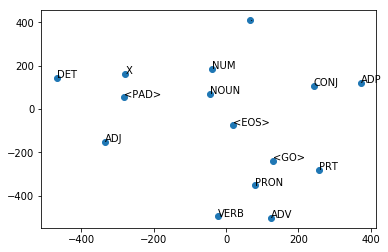

In [31]:
np.random.seed(300)
embeddings = english_data.embeddings
X_english = optimizer.sess.run(embeddings)
res_english = TSNE(n_components=2, verbose=2, perplexity=5).fit_transform(X_english)
x, y = res_english.T

fig, ax = plt.subplots()
ax.scatter(x, y)
for i, txt in enumerate(english_data.unique_characters):
    ax.annotate(txt, (x[i], y[i]))
plt.show()

[t-SNE] Computing 14 nearest neighbors...
[t-SNE] Indexed 15 samples in 0.000s...
[t-SNE] Computed neighbors for 15 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 15 / 15
[t-SNE] Mean sigma: 0.802394
[t-SNE] Computed conditional probabilities in 0.001s
[t-SNE] Iteration 50: error = 52.4626579, gradient norm = 0.1964100 (50 iterations in 0.013s)
[t-SNE] Iteration 100: error = 58.8850670, gradient norm = 0.2956732 (50 iterations in 0.014s)
[t-SNE] Iteration 150: error = 64.9974747, gradient norm = 0.1955538 (50 iterations in 0.013s)
[t-SNE] Iteration 200: error = 54.1326103, gradient norm = 0.1912456 (50 iterations in 0.013s)
[t-SNE] Iteration 250: error = 76.9935379, gradient norm = 0.7933131 (50 iterations in 0.013s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.993538
[t-SNE] Iteration 300: error = 1.1658531, gradient norm = 0.0011867 (50 iterations in 0.016s)
[t-SNE] Iteration 350: error = 0.9588557, gradient norm = 0.0004574 (50 i

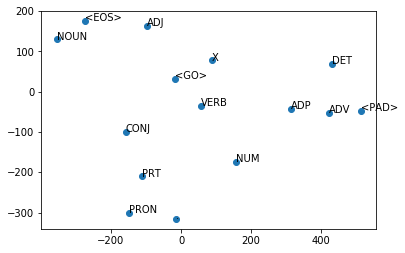

In [11]:
np.random.seed(300)
embeddings = french_data.embeddings
X_french = french_optimizer.sess.run(embeddings)
res_french = TSNE(n_components=2, verbose=2, perplexity=5).fit_transform(X_french)
x, y = res_french.T

fig, ax = plt.subplots()
ax.scatter(x, y)
for i, txt in enumerate(french_data.unique_characters):
    ax.annotate(txt, (x[i], y[i]))
plt.show()

In [27]:
diffs = []
visited = []
for pos in english_data.unique_characters:
    visited.append(pos)
    if pos[-1] == ">" or pos == u"X" or pos == u".":
        continue
    for second_pos in english_data.unique_characters:
        if second_pos in visited:
            continue
        if second_pos[-1] == ">" or second_pos == u"X" or second_pos == u".":
            continue
        idx1 = english_data.char2index[pos]
        idx2 = english_data.char2index[second_pos]
        diff_french = np.linalg.norm(X_french[idx1] - X_french[idx2])
        diff_english = np.linalg.norm(X_english[idx1] - X_english[idx2])
        
        diffs.append([pos, second_pos, diff_french, diff_english, np.abs(diff_french-diff_english)])

In [29]:
diffs = sorted(diffs, key=lambda x: x[4])
print ["POS1", "POS2", "French distance", "English distance", "Difference in language distance"]
for diff in diffs:
    print diff

['POS1', 'POS2', 'French distance', 'English distance', 'Difference in language distance']
[u'VERB', u'NUM', 1.8247626, 1.8020245, 0.022738099]
[u'ADV', u'NUM', 2.365937, 2.3032146, 0.062722445]
[u'ADV', u'PRT', 1.8472359, 1.7683926, 0.078843355]
[u'ADP', u'CONJ', 1.4894204, 1.6267277, 0.13730729]
[u'NOUN', u'DET', 2.8471708, 2.6858387, 0.16133213]
[u'ADP', u'ADJ', 2.4979281, 2.6593592, 0.16143107]
[u'NOUN', u'PRT', 2.1778231, 2.3997245, 0.22190142]
[u'PRT', u'PRON', 1.0737046, 1.30162, 0.22791541]
[u'ADP', u'PRON', 2.4608812, 2.7418683, 0.28098702]
[u'PRON', u'CONJ', 1.955707, 2.2442217, 0.28851473]
[u'PRT', u'ADJ', 2.5628846, 2.8555748, 0.29269028]
[u'NOUN', u'ADJ', 2.4969866, 2.8114889, 0.31450224]
[u'NOUN', u'ADP', 2.4770756, 2.8343289, 0.35725331]
[u'CONJ', u'ADJ', 2.2189159, 1.8611804, 0.35773551]
[u'PRT', u'NUM', 1.9371662, 2.2966437, 0.35947752]
[u'DET', u'ADJ', 3.3750968, 3.0076208, 0.36747599]
[u'NOUN', u'VERB', 2.5135429, 2.1404622, 0.37308073]
[u'ADV', u'ADJ', 3.2653687, 2.

In [41]:
print french_to_universal(french_tagger.tag("Il l'a tapoté doucement sur le dos".split(" ")))
print english_to_universal(nltk.pos_tag("he gently patted her on the back".split(" ")))

print "=" * 100
print french_to_universal(french_tagger.tag("I wash myself.".split(" ")))
print english_to_universal(nltk.pos_tag("Je me lave.".split(" ")))

[(u'Il', u'PRON'), (u"l'a", u'VERB'), (u'tapot\xe9', u'VERB'), (u'doucement', u'ADV'), (u'sur', u'ADP'), (u'le', u'DET'), (u'dos', u'NOUN')]
[('he', u'PRON'), ('gently', u'ADV'), ('patted', u'VERB'), ('her', u'PRON'), ('on', u'ADP'), ('the', u'DET'), ('back', u'NOUN')]
[(u'I', u'ADJ'), (u'wash', u'NOUN'), (u'myself.', u'ADJ')]
[('Je', u'NOUN'), ('me', u'PRON'), ('lave.', u'VERB')]
